In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import time
import numpy as np
from matplotlib import pyplot as plt
data_dir = './data/cinic-10_image_classification_challenge-dataset/train/'
from tensorflow.keras.regularizers import l1_l2
input_shape = (32, 32, 3)

# load data

In [18]:
def load_and_preprocess_image(image_path, label):
    # Load image
    image = tf.io.read_file(image_path)
    # Decode PNG image to tensor
    image = tf.image.decode_png(image, channels=3)  # Adjust channels according to your images
    # Normalize pixel values to range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label


def preprocess_data():

    class_names = os.listdir(data_dir)

    image_paths = []
    labels = []
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image_paths.append(image_path)
            labels.append(class_names.index(class_name))

    # Create TensorFlow Dataset from the loaded data
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)

    dataset = dataset.shuffle(buffer_size=10000)

# Split the dataset into train, validation, and test sets
    train_size = int(0.8 * len(dataset))
    test_size = int(0.2 * len(dataset))

    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(32)
    test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(32)
    return train_dataset, test_dataset

# pre-made dataset from cifar dataset

In [19]:
train_dataset, test_dataset = preprocess_data()

# CNN definition

In [20]:
def cnn(input_shape, elastic_net=False, l1=0.01, l2=0.01, dropout_rate=0.5):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l1_l2(l1, l2))) # output shape is 30x30x32
    model.add(layers.MaxPooling2D((2, 2))) # output shape is 15x15x32
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1, l2))) # output shape is 13x13x64
    model.add(layers.MaxPooling2D((2, 2))) # output shape is 6x6x64
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1, l2))) # 4x4x64

    # Dense layers
    model.add(layers.Flatten()) # 1024
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1, l2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(10, activation='softmax', kernel_regularizer=l1_l2(l1, l2)))

    return model


### searching for elastic net regularizer
grid search, because there's two parameters - l1 and l2

In [23]:
histories = {}
l1_range = np.linspace(0, 1, 10)  # Example: 10 values between 0 and 1
l2_range = np.linspace(0, 1, 10)  # Example: 10 values between 0 and 1

# Generate candidate combinations using grid search
search_space = [(l1, l2) for l1 in l1_range for l2 in l2_range]
for l1, l2 in search_space:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)    
    model = cnn(input_shape, True, l1, l2, 0.5)
    model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    print(f'l1 = {l1}, l2 = {l2}')
    history = model.fit(train_dataset, epochs = 5)    
    test_loss, test_acc = model.evaluate(test_dataset)
    histories[(l1, l2)] = {'history': history.history,
                        'test_loss': test_loss,
                        'test_acc': test_acc}

l1 = 0.0, l2 = 0.0
Epoch 1/5
2250/2250 [==============================] - 32s 11ms/step - loss: 1.7577 - accuracy: 0.3706
Epoch 2/5
2250/2250 [==============================] - 33s 12ms/step - loss: 1.4970 - accuracy: 0.4550
Epoch 3/5
2250/2250 [==============================] - 31s 11ms/step - loss: 1.4155 - accuracy: 0.4888
Epoch 4/5
2250/2250 [==============================] - 31s 11ms/step - loss: 1.3661 - accuracy: 0.5063
Epoch 5/5
563/563 [==============================] - 11s 5ms/step - loss: 3.8904 - accuracy: 0.2519
l1 = 0.0, l2 = 0.1111111111111111
Epoch 1/5
2250/2250 [==============================] - 55s 18ms/step - loss: 3.3628 - accuracy: 0.3546
Epoch 2/5
2250/2250 [==============================] - 66s 25ms/step - loss: 1.9381 - accuracy: 0.3718
Epoch 3/5
2250/2250 [==============================] - 64s 22ms/step - loss: 1.9091 - accuracy: 0.3729
Epoch 4/5
2250/2250 [==============================] - 88s 31ms/step - loss: 1.8902 - accuracy: 0.3790
Epoch 5/5
563/563 [====

KeyboardInterrupt: 

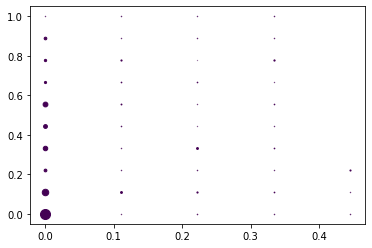

In [31]:
for (l1, l2) in histories:
    plt.scatter(l1, l2, s = histories[(l1, l2)]['test_acc']*400, c = histories[(l1, l2)]['test_acc'])

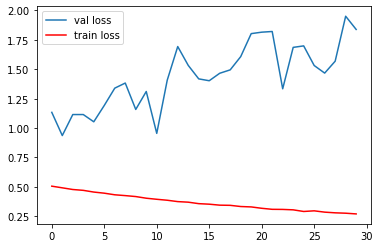

In [49]:
plt.plot(history.history['val_loss'], label = 'val loss')
plt.plot(history.history['loss'], c = 'red', label = 'train loss')
plt.legend()

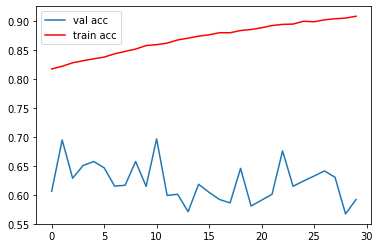

In [50]:
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.plot(history.history['accuracy'], c = 'red', label = 'train acc')
plt.legend()